In [9]:
# --- Loading libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_final = pd.read_csv("../../assets/files/datasets/perfect_tidy_data.csv")

## Analysis prep script (full, copy-paste ready)

## From tidy data to analysis-ready tables
print("--- PREPARING DATA FOR ANALYSIS ---")

# --- ANALYSIS PREP ---
# This block creates the 'df_plot' DataFrame for all visualizations
# 1. Get the baseline attendance (Year 0) for each event
df_y0_baseline = df_final[
    df_final['Year_vs_Relegation'] == 0
][['Relegation_Event_ID', 'Attendance']].rename(columns={'Attendance': 'Attendance_Y0_Baseline'})

# 2. Merge this baseline back onto the main df
df_plot = pd.merge(df_final, df_y0_baseline, on='Relegation_Event_ID', how='left')

# 3. Calculate the Pct Change vs. Year 0 for all years
df_plot['Pct_Change_vs_Y0'] = (
    (df_plot['Attendance'] - df_plot['Attendance_Y0_Baseline']) / 
    df_plot['Attendance_Y0_Baseline']
)

# 4. Get the *key outcome* from Year 1 (the first post-relegation season)
df_y1_outcome = df_final[
    df_final['Year_vs_Relegation'] == 1
][['Relegation_Event_ID', 'Year_End_Outcome']].rename(columns={'Year_End_Outcome': 'Outcome_Group'})

# 5. Merge this outcome group onto the whole plot dataset
df_plot = pd.merge(df_plot, df_y1_outcome, on='Relegation_Event_ID', how='left')


# 5.5: IMPUTE 2024-25 OUTCOMES ---
# The Y+1 outcome for the 2023-24 cohort is NA. We impute it manually.
print("Imputing outcomes for 2023-24 cohort...")

# Define our imputations based on likely 2024-25 season-end performance
impute_map = {
    'Burnley 2023-24': 'Promoted',
    'Sheffield United 2023-24': 'Survived', # Assuming playoffs = Survived
    'Luton Town 2023-24': 'Relegated'
}

# Apply the imputation
# This finds rows where Outcome_Group is NA and maps the Event ID to our new value
df_plot['Outcome_Group'] = df_plot['Outcome_Group'].fillna(
    df_plot['Relegation_Event_ID'].map(impute_map)
)
print("Imputation complete.")

# 6. Convert Pct_Change to a percentage number (e.g., 0.05 -> 5)
df_plot['Pct_Change_vs_Y0_Display'] = df_plot['Pct_Change_vs_Y0'] * 100

# 7. Calculate Per-Game metrics on the fly
df_plot['Goals_For_Per_Game'] = df_plot['Goals_For_History'] / df_plot['Games_Played_History']
df_plot['Points_Per_Game'] = df_plot['Points_History'] / df_plot['Games_Played_History']

# 8. Define the FINAL anomaly list
# We are KEEPING Wimbledon, as it's a valid case study.
anomaly_events = [
    'Middlesbrough 1992-93', # Rebuild
    'Sunderland 1996-97',    # New stadium
    'Leicester City 2001-02', # New stadium
    'Bolton Wanderers 1995-96'  # New stadium (in Y+2)
]

# 9. Create the FINAL filtered DataFrame for plotting
df_plot_filtered = df_plot[~df_plot['Relegation_Event_ID'].isin(anomaly_events)]
print(f"Removed {len(df_plot) - len(df_plot_filtered)} total data points for structural anomalies.")

# 10. Create the cleaner plot labels
label_map = {
    'Promoted': 'Promoted (Back in PL)',
    'Survived': 'Survived (Still in Champ)',
    'Relegated': 'Relegated (Down to L1)'
}
df_plot['Plot_Group_Label'] = df_plot['Outcome_Group'].map(label_map)
df_plot_filtered['Plot_Group_Label'] = df_plot_filtered['Outcome_Group'].map(label_map)

print("--- Analysis data is ready. ---")

--- PREPARING DATA FOR ANALYSIS ---
Imputing outcomes for 2023-24 cohort...
Imputation complete.
Removed 16 total data points for structural anomalies.
--- Analysis data is ready. ---


C:\Users\eoind\AppData\Local\Temp\ipykernel_2680\1986190108.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot_filtered['Plot_Group_Label'] = df_plot_filtered['Outcome_Group'].map(label_map)


I'm a Burnley fan. With our recent promotion to the Premier League we are firmly consolidated as a yoyo club par excellence - we rank joint-4th with Sunderland on the Yoyo-meter (below). So what better time to assess some of the impacts of relegation from the Premier League? Because it's never too early to plan ahead.

In this article, I'll be exploring if, how and for how long Premier League relegation disrupts attendances. We'll also examine some mitigating factors. Does attractive football help maintain attendances? Is mid-table mediocrity worse for attendances than being in a relegation dogfight?

The dataset I have designed for this project combines a few different online resources and also engineers some variables. You can read about it and download it [here](../too-messy-to-melt/).

### Yoyometer

| Club                 | PL Relegations | Championship Promotions | Current League    |
|----------------------|----------------|-------------------------|-------------------|
| Norwich City         | 6              | 5                       | Championship      |
| West Bromwich Albion | 5              | 5                       | Championship      |
| Leicester City       | 5              | 5                       | Championship      |
| Burnley              | 4              | 5                       | Premier League    |
| Sunderland           | 4              | 5                       | Premier League |
| Crystal Palace       | 4              | 4                       | Premier League    |
| Middlesbrough        | 4              | 4                       | Championship      |
| Watford              | 4              | 4                       | Championship      |
| Sheffield United     | 4              | 3                       | Championship   |
| Southampton          | 3              | 2                       | Championship      |

## Methodology

### Data Collection
For this project, I gathered attendance, league position, and performance data for every club relegated from the Premier League, spanning a four-year period for each event:

1. Year -1: The season before the Premier League relegation season.
2. Year 0: The Premier League season that resulted in relegation.
3. Year +1: The first season after relegation (in the Championship).
4. Year +2: The second season after relegation.

:::{.callout-note}
A temporary fifth year of data (Year +3) was programmatically generated to extract the league tier, which is used to determine the final outcome of the Year +2 season. After achieving that, the temporary Year +3 data was dropped.
:::

#### Sources
1. For **Attendance data**, I referenced [European-Football-Statistics.co.uk](https://www.european-football-statistics.co.uk/index1.htm).  

2. For both **Position** and **Performance** data I relied on the [Fjelstul English Football Database](https://www.github.com/jfjelstul/englishfootball), which is a comprehensive catalogue of English Football from 1888-2024. I used a small section from the standings dataset, but he also has datasets covering seasons, teams, matches, and appearances. Worth a look if you have a project in mind.

:::{.callout-note}
Dr. Fjelstul's database is copyrighted ("© 2024 Joshua C. Fjelstul, Ph.D.") but accessible via the [CC-BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/legalcode). I will also be making my own dataset available under the same CC-BY-SA 4.0 license.
:::

### Dataset
In addition to merging attendance data with position data and performance data, some key features of the dataset had to be engineered. I needed `Year_vs_Relegation` and `Year_End_Outcome` columns in order to group by season outcomes and to track attendance over time.

For my *single source of truth* dataset, I am using the raw values for performance (Points, Goals, etc.) and calculating per-game metrics as needed for analysis. Below is a snapshot of the final, tidy dataset.

In [10]:
df_final.head()

,Relegation_Event_ID,Team,Season,Tier,Position,Attendance,Year_vs_Relegation,Year_End_Outcome,Games_Played_History,Wins_History,Goals_For_History,Goals_Against_History,Points_History
0,Aston Villa 2015-16,Aston Villa,2014-15,1.0,17.0,34133.0,-1,Survived,38.0,10.0,31.0,57.0,38.0
1,Aston Villa 2015-16,Aston Villa,2015-16,1.0,20.0,33690.0,0,Relegated,38.0,3.0,27.0,76.0,17.0
2,Aston Villa 2015-16,Aston Villa,2016-17,2.0,13.0,32107.0,1,Survived,46.0,16.0,47.0,48.0,62.0
3,Aston Villa 2015-16,Aston Villa,2017-18,2.0,4.0,32097.0,2,Survived,46.0,24.0,72.0,42.0,83.0
4,Barnsley 1997-98,Barnsley,1996-97,2.0,2.0,11356.0,-1,Promoted,46.0,22.0,76.0,55.0,80.0



#### Limitations  
As tidy as it is, there are still some pretty big limitations to this dataset:

**Season-Level Granularity**:  
- The dataset aggregates data at the season level, meaning any within-season events—such as managerial changes, mid-season form swings, or cup runs—are not captured.

**Loss of Match-Level Variability**:  
- Attendance figures are averaged per season, so high- or low-attendance matches (e.g., local derbies) are smoothed out.

**External Influences Aren't Captured** (with the exception of COVID)
- Factors such as weather, ticket pricing, fan protests, or extraordinary events (e.g., stadium closures) are not included. These could all contribute to unexplained variance in attendance. However, I do think that over a season, these sorts of things tend to balance themselves out. Except for COVID and stadium reconstructions, which both need special handling.

**Handling COVID-19**  
- A quick note on the elephant in the stadium: the 2019-20 and 2020-21 seasons. Since many games were played with zero or partial attendance, including them as "0" would catastrophically skew the averages. To prevent this, the data cleaning pipeline explicitly searches for any attendance data marked "COVID" and converts it to a null value (`pd.NA`). All subsequent averaging functions automatically ignore these null values, so the analysis is not contaminated by seasons played behind closed doors.

**Handling Stadium Anomalies**
The data contains three major structural anomalies where attendance was dictated by stadium construction, not fan sentiment or on-pitch performance:

1. Middlesbrough (1993-94): Attendance artificially plummeted due to a stadium rebuild.

2. Sunderland (1997-98): Attendance saw a massive, artificial spike from moving to the new Stadium of Light.

3. Leicester City (2002-03): A similar spike occurred when the club moved to the Walkers Stadium (now called the King Power Stadium).

To prevent these outliers from skewing my interpretations, these specific team-seasons were identified. Unless I specifically mention their inclusion, you can safely assume they were filtered out of the analysis.

#### Downloadable
If you still want the dataset for analysis after all that, or you're wondering why I keep calling things tidy, then check out [Too Messy to Melt](../too-messy-to-melt/) for a technical guide to how this dataset was constructed. Or you can inspect the data dictionary and grab the downloadable dataset straight from my GitHub.

## Analysis

### Increased attendance after relegation?

Let's start on a positive note. On 10 occasions, teams managed to increase their average attendance in the first season (Y+1) immediately following relegation.

In [11]:
#| output: true
#| echo: false
#| cap: "Table 1: Teams with Increased Attendance in Year +1"

# Use the 'df_plot' DataFrame (which includes all data)
# 1. Filter for Year +1
table1 = df_plot[
    (df_plot['Year_vs_Relegation'] == 1) & 
    (df_plot['Pct_Change_vs_Y0_Display'] > 0)
].copy()

table1 = table1.sort_values(by='Pct_Change_vs_Y0_Display', ascending=False)

# 4. Select and rename columns for display
table1_display = table1[['Team', 'Attendance_Y0_Baseline', 'Attendance', 'Pct_Change_vs_Y0_Display']]
table1_display.columns = ['Team', 'Attendance (Y0)', 'Attendance (Y+1)', 'Change (%)']

# This returns a stylable HTML object instead of an uncallable dataframe
table1_display.style.format({
    'Attendance (Y0)': '{:.0f}',
    'Attendance (Y+1)': '{:.0f}',
    'Change (%)': '{:.2f}'
}).hide() # This replaces index=False

Team,Attendance (Y0),Attendance (Y+1),Change (%)
Sunderland,20865,33492,60.52
Leicester City,19835,29231,47.37
Nottingham Forest,21910,23051,5.21
Ipswich Town,24426,25455,4.21
Burnley,19399,19953,2.86
Newcastle United,49754,51106,2.72
Norwich City,24350,24952,2.47
Crystal Palace,14992,15248,1.71
Luton Town,11244,11420,1.57
Middlesbrough,29848,29994,0.49


And I have to give a shoutout to Burnley and, indeed, to Vincent Kompany because he certainly galvanised the supporters that season.

A couple teams really jump out. Both Sunderland and Leicester City moved into new stadia the year after their relegation, and this gave them a considerable bump. They must have been absolutely packing out their stadia the season prior and had supporters banging down the doors to get in. Sunderland even managed to add over 5,000 supporters to their tally the season after relegation, despite the fact that they were still stuck in the Championship. Leicester also increased attendances in 2003-04, by 1,600 to 30,983. But they spent that season in the Premier League, so it's less startling to see an increase.

Newcastle also catch the eye, but not just because their 51,106 fans in 2016-17 is an extraordinary number - everyone knows Newcastle is a football-mad city. What's truly insightful is comparing their two most recent relegations.

- After relegation in 2009, the club saw a significant 11% *drop* in average attendance.

- After relegation in 2016-17, The club saw a 2.7% *increase* in attendance.

That's 13.7-point swing. The club was massive in both scenarios, so "big club" is a constant. The most obvious variable is "vibes."

At the end of 2008-09 Newcastle's all-time record goalscorer and local lad Alan Shearer had stepped up to try and save Newcastle. He only had 8 games to do it in. No matter the outcome, he was supposed to stay on as manager into the next season. But they got relegated and he didn't get offered a contract for the next season. There's no doubt that this was a low point between Newcastle fans and their owner Mike Ashley. And this was borne out in the 2009-10 attendances.  

2016-17 was the polar opposite. Similar to how Burnley fell under the spell of Vincent Kompany in 2022/23, Newcastle fans had a great relationship with Rafael Benitez, even if Mike Ashley was still as loathed as ever. Benitez was hired towards the end of their 2015/16 relegation season and it was considered quite a coup to attract this Champions League-winning manager to a Championship-bound club. So the fans showed their appreciation during his first full season in charge with record-breaking attendances.

<!--Typically, we start to see the cracks in season 2 outside the top flight. Filtering out teams like Leicester who were promoted at the first attempt and had Premier League fixtures to pull in the fans, only 6 teams see attendance figures in the black by season 2.-->

## Anomalies

Those positive stories are, unfortunately, anomalies. And they are not the only ones. A box plot of all post-relegation data (Y+1 and Y+2) shows the wild variance in outcomes.

C:\Users\eoind\AppData\Local\Temp\ipykernel_2680\4060016492.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\eoind\AppData\Local\Temp\ipykernel_2680\4060016492.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels)


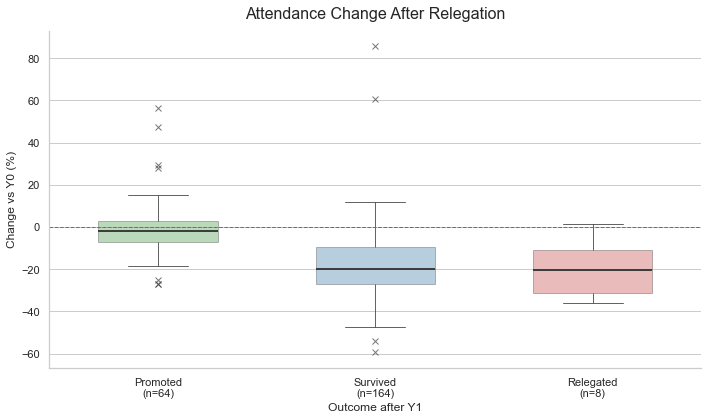

In [26]:
#| output: true
#| fig-cap: "Distribution of attendance change (Y+1 & Y+2) by outcome, including all outliers and sample sizes."
#| echo: false
#| fig-format: png

palette = {
    "Promoted": "#2ca02c",   # green
    "Survived": "#1f77b4",   # blue
    "Relegated": "#d62728",  # red
}

plot_order = ["Promoted", "Survived", "Relegated"]

df_boxplot_data = df_plot[df_plot["Year_vs_Relegation"].isin([1, 2])].copy()
df_boxplot_data["Pct_Change_vs_Y0_Display"] = df_boxplot_data["Pct_Change_vs_Y0_Display"].astype(float)

counts = df_boxplot_data["Outcome_Group"].value_counts()
xlabels = [f"{g}\n(n={counts.get(g, 0)})" for g in plot_order]

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(
    data=df_boxplot_data,
    x="Outcome_Group",
    y="Pct_Change_vs_Y0_Display",
    order=plot_order,
    palette=palette,
    width=0.55,
    showfliers=True,
    flierprops=dict(marker="x", markersize=6, alpha=0.7),  # neutral ×
    boxprops=dict(alpha=0.35),
    whiskerprops=dict(alpha=0.8),
    capprops=dict(alpha=0.8),
    medianprops=dict(linewidth=2),
    ax=ax,
)

ax.axhline(0, linestyle="--", linewidth=1)
ax.set_title("Attendance Change After Relegation", fontsize=16, pad=12)
ax.set_xlabel("Outcome after Y1")
ax.set_ylabel("Change vs Y0 (%)")
ax.set_xticklabels(xlabels)

sns.despine(ax=ax)
plt.tight_layout()
plt.show()

The plot above clearly shows several extreme statistical outliers (the dots) that are skewing the data. To understand what they are, we can use the `1.5 * IQR` rule (the same logic the box plot uses) to print a list of them.

### Outlier Hunt Using the 1.5 * IQR Rule

In [20]:
#| output: true
#| echo: false

df_hunt = df_plot[df_plot['Year_vs_Relegation'].isin([1, 2])].copy()
df_hunt['Pct_Change_vs_Y0_Display'] = df_hunt['Pct_Change_vs_Y0_Display'].astype(float)

rows = []
for group in ['Promoted', 'Survived', 'Relegated']:
    group_df = df_hunt[df_hunt['Outcome_Group'] == group]
    if group_df.empty:
        continue

    q1 = group_df['Pct_Change_vs_Y0_Display'].quantile(0.25)
    q3 = group_df['Pct_Change_vs_Y0_Display'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    outliers = group_df[
        (group_df['Pct_Change_vs_Y0_Display'] < lower) |
        (group_df['Pct_Change_vs_Y0_Display'] > upper)
    ].copy()

    if outliers.empty:
        continue

    # Build a reader-friendly slice (no IDs, no bounds)
    cols = ['Team', 'Season', 'Year_vs_Relegation', 'Pct_Change_vs_Y0_Display']
    outliers = outliers[cols]
    outliers.insert(0, 'Outcome_Group', group)

    rows.append(outliers)

outliers_table = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(
    columns=['Outcome_Group', 'Team', 'Season', 'Year_vs_Relegation', 'Pct_Change_vs_Y0_Display']
)

outliers_table = outliers_table.sort_values(
    by='Pct_Change_vs_Y0_Display',
    ascending=False
)

outliers_table.rename(columns={
    'Outcome_Group': 'Outcome',
    'Year_vs_Relegation': 'Year',
    'Pct_Change_vs_Y0_Display': 'Change vs Y0 (%)'
}).style.format({
    'Change vs Y0 (%)': '{:+.1f}'
}).hide(axis='index')

Outcome,Team,Season,Year,Change vs Y0 (%)
Survived,Sunderland,1998-99,2,+85.7
Survived,Sunderland,1997-98,1,+60.5
Promoted,Leicester City,2003-04,2,+56.2
Promoted,Leicester City,2002-03,1,+47.4
Promoted,Bolton Wanderers,1997-98,2,+29.4
Promoted,Sunderland,2007-08,2,+27.8
Promoted,Fulham,2019-20,1,-25.3
Promoted,Hull City,2015-16,1,-27.0
Promoted,Birmingham City,2008-09,1,-27.1
Survived,Wimbledon,2000-01,1,-53.9


### Case-by-Case Anomaly Handling

This list gives us a clear action plan. To understand the true relationship between performance and attendance, we must filter out cases where attendance was driven by external structural factors, not fan behavior.

| Relegation Event       | Year       | Change            | Outlier Type         | Decision | Reason |
|------------------------|------------|-----------------|-------------------|----------|--------|
| Sunderland 1996-97     | Y+1, Y+2   | +61%, +86%      | Stadium Anomaly    | Remove   | Moved to the new, much larger Stadium of Light. |
| Leicester City 2001-02 | Y+1, Y+2   | +47%, +56%      | Stadium Anomaly    | Remove   | Moved to the new Walkers (King Power) Stadium. |
| Bolton Wanderers 1995-96 | Y+2      | +29%            | Stadium Anomaly    | Remove   | Y+2 (1997-98 season) was their first in the new Reebok Stadium. |
| Middlesbrough 1992-93  | Y+1        | -38%            | Stadium Anomaly    | Remove   | Attendance nosedived during a stadium rebuild. |
| Wimbledon 1999-2000    | Y+1, Y+2   | -54%, -59%      | Toxicity | Keep   | To be continued... |
| Hull City 2014-15      | Y+1        | -27%            | Toxicity    | Keep     | To be continued... |
| Birmingham City 2007-08 | Y+1       | -27%            | Toxicity  | Keep     | To be continued... |

Now, with the data properly filtered, let's look at the real story.

And we may as well start with that Toxicity factor I mentioned above.

## The Toxicity Factor: When Loyalty Snaps (and When It Doesn't)  

On-pitch performance isn't the only driver. The data shows that a toxic or broken relationship between a club's owners and its fans can act as a powerful accelerant for an attendance collapse.

These aren't just "bad vibes"; they are measurable, real-world events:

Hull City (2014-15): The -27% drop in Y+1 wasn't just about relegation. It directly coincided with a fan mutiny over the owners' deeply unpopular attempt to rebrand the club as "Hull Tigers."

Birmingham City (2007-08): A similar story. Their -27% nosedive in Y+1 was fueled by widespread fan protests calling for the board to resign.

Newcastle (2009-10 vs. 2016-17): This is the perfect A/B test. In both 2009 and 2016, the club had the same toxic ownership under Mike Ashley.

In 2009-10, the vibe was poisonous. The result? A significant 11% drop in attendance.

In 2016-17, a different "vibe" won. Hiring (and keeping) Rafa Benitez was such an unexpected coup that his popularity papered over the cracks, galvanizing the fanbase and leading to a 2.7% increase.

Wimbledon (1999-2000): This is the ultimate case study. They were already a "homeless" club, playing at Crystal Palace's Selhurst Park during their Y0 relegation season. Their baseline attendance was already depressed. When they lost their Premier League status, attendance collapsed by -59%. The showpiece occasion of a Premier League game seems to have been the last thread holding that displaced fanbase together. When it snapped, so did the club.

## A Results Business

Next up, we'll look at our `Year_End_Outcome` variable. Let's plot the attendance change over time, grouping teams by whether they were Promoted, Survived, or Relegated in their first post-relegation season.

C:\Users\eoind\AppData\Local\Temp\ipykernel_2680\123933427.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


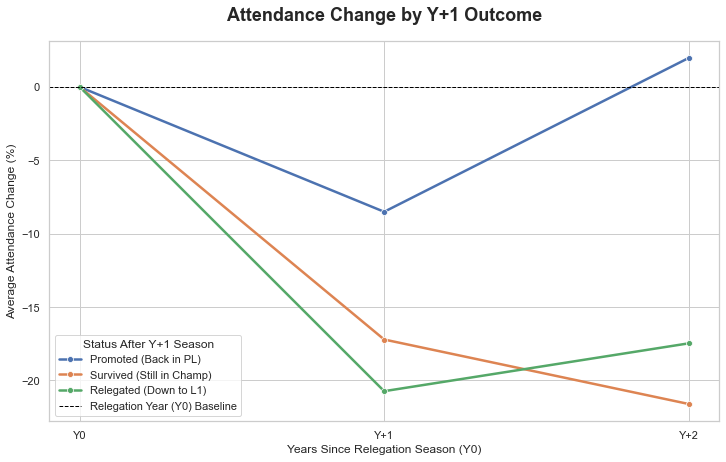

In [14]:
#| output: true
#| echo: false
#| fig-cap: "Average attendance change (anomalies removed) relative to the relegation season (Y0), grouped by the team's outcome in their first post-relegation season (Y+1)."

# We use the pre-filtered 'df_plot_filtered' DataFrame
# (This was defined in the hidden setup block)

plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Define the order for the new labels
label_order = [
    'Promoted (Back in PL)',
    'Survived (Still in Champ)',
    'Relegated (Down to L1)'
]

# Create the lineplot
sns.lineplot(
    data=df_plot_filtered[df_plot_filtered['Year_vs_Relegation'].isin([0, 1, 2])], 
    x='Year_vs_Relegation',
    y='Pct_Change_vs_Y0_Display',
    hue='Plot_Group_Label',    # <-- USE NEW LABEL COLUMN
    hue_order=label_order,     # <-- USE NEW LABEL ORDER
    marker='o',
    lw=2.5,
    ci=None 
)

plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Relegation Year (Y0) Baseline')

# --- Calculate new numbers for the prose ---
line_plot_data = df_plot_filtered[df_plot_filtered['Year_vs_Relegation'].isin([1, 2])]
line_plot_avg = line_plot_data.groupby(['Outcome_Group', 'Year_vs_Relegation'])['Pct_Change_vs_Y0_Display'].mean().reset_index()
line_plot_avg.style.format({
    'Pct_Change_vs_Y0_Display': '{:.1f}'
}).hide()
# --- End calculation ---

plt.title('Attendance Change by Y+1 Outcome',
          fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Years Since Relegation Season (Y0)', fontsize=12)
plt.ylabel('Average Attendance Change (%)', fontsize=12)
plt.xticks([0, 1, 2], ['Y0', 'Y+1', 'Y+2'])
plt.legend(title='Status After Y+1 Season')
plt.show()

Irrespective of season outcome, relegated teams *on average* lose fans. And there seems to be a clear correlation between team performance and attendance. Moreover, it does seem that performance affects attendances.

**Promoted (Green Line)**: Teams that bounce straight back (like Burnley) see their Y+1 attendance drop minimized to just -8.6%. By Y+2, they are back in the Premier League, and attendance recovers to surpass its pre-relegation level by 2%.

**Survived (Blue Line)**: Teams that "survive" and stay in the Championship see a much larger initial drop of -17.2%. Worse, by Y+2, that optimism fades and attendance dwindles further to -21.6%.

**Relegated (Orange Line)**: Teams that enter freefall and plummet into League 1 see a catastrophic -28% drop in Y+1, which slightly recovers to -24% in Y+2.

## Would champagne football help?

If you're stuck in the Championship, can you at least keep the fans entertained with attacking football?

To test this, I've plotted `Goals_For_Per_Game` against the percentage change in attendance for all post-relegation seasons (Y+1 and Y+2), again grouped by the team's outcome and with the stadium anomalies removed.

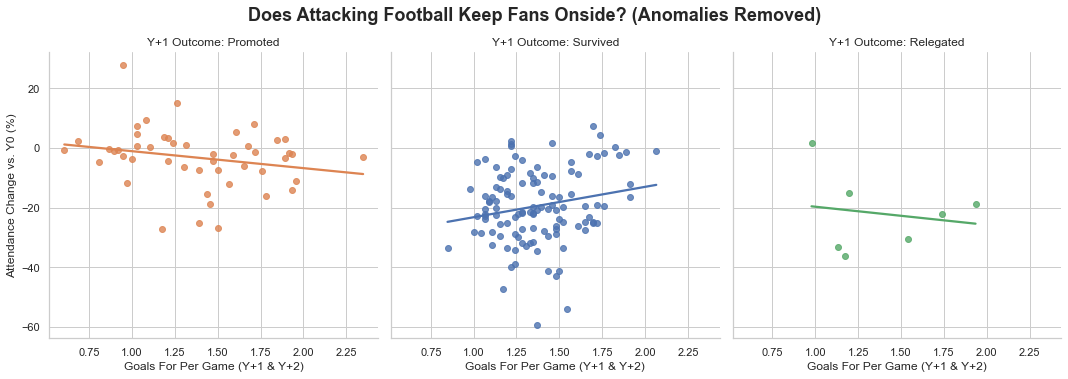

In [15]:
#| output: true
#| echo: false
#| fig-cap: "Scatter plots (all structural anomalies removed) showing the relationship between attacking football and the percentage change in attendance."

# We use the 'df_plot_filtered' we already made
df_scatter = df_plot_filtered[df_plot_filtered['Year_vs_Relegation'].isin([1, 2])].copy()

# --- Type Conversion Fix ---
df_scatter['Pct_Change_vs_Y0_Display'] = df_scatter['Pct_Change_vs_Y0_Display'].astype('float64')
df_scatter['Goals_For_Per_Game'] = df_scatter['Goals_For_Per_Game'].astype('float64')

# Create a faceted scatter plot with regression lines
g = sns.lmplot(
    data=df_scatter, # <-- Use the final filtered DataFrame
    x='Goals_For_Per_Game',
    y='Pct_Change_vs_Y0_Display',
    col='Outcome_Group',
    hue='Outcome_Group',
    col_order=['Promoted', 'Survived', 'Relegated'],
    height=5,
    aspect=1,
    ci=None
)

g.fig.suptitle('Does Attacking Football Keep Fans Onside? (Anomalies Removed)',
               fontsize=18, fontweight='bold', y=1.05)
g.set_axis_labels('Goals For Per Game (Y+1 & Y+2)', 'Attendance Change vs. Y0 (%)')
g.set_titles("Y+1 Outcome: {col_name}")

plt.show()

The answer seems to be: yes, but only if you have nothing else to play for.

For Survived teams, there is a fairly clear positive relationship. If a team is destined for another year of mid-table Championship football, entertainment value (scoring goals) seems to help keep traffic coming through the turnstiles.

<!-- Luton really buck the trend for League 1-destined sides. And because there are so few teams who are relegated from the Premier League to League 1 in consecutive seasons, their outlier status has a huge impact on the data, dropping the averages by almost 8%. But can Luton really be considered anomalous when the data population is so small? In my view, yes. First of all, Luton had an emotional relegation season. Their captain Tom Lockyer suffered a cardiac arrest mid-game. Fortunately, he survived and has been on a road to recovery ever since with the view to playing again. Moreover, Luton battled very bravely against relegation despite these traumatising events and despite being financial minnows. Luton were a uniquely united club during their relegation season. However, that is not the only explanation. The other is that Luton are another stadium-constrained side. Kenilworth Road is famously tiny, and was a peculiar relic among Premier League stadiums. Luton have received approval for a stadium rebuild that will double its capacity. Based on their increased attendances post-relegation, Luton are another case of a club where demand has exceeded supply for some time.

Just a quick note on Burnley, who were in the black during their Kompany-led campaign but have lost almost 8% this season. There are a few factors at play. First, morale sank during Kompany's PL season. Burnley were truly awful and the core of their Championship-winning side was cast aside in favour of new recruits - an inexplicable decision in the view of many fans. Moreover, ALK capital - the ownership group - made some ill-judged and patronising comments to supporters for not bringing a positive enough atmosphere to Turf Moor. In a nutshell, the mood was bleak by the end of 2022-23. Kompany's departure and subsequent replacement by Scott Parker failed to excite fans. Nor did selling half the first team squad and sitting through a million 0-0 draws. Despite the successful campaign, Parker-ball has been a bit of a slog. Sidenote: I was a huge Parker skeptic at first but I think he has brought the solidity Burnley needed and, as the season has gone on, a more cohesive team has taken shape, the football has yielded more goals and the fanbase has gotten on side. In any case, this all goes to highlight that there are complexities behind the averages I am presenting here.-->

## Conclusions
- Teams can typically expect to lose 16-22% of their attendance after relegation if they don't bounce straight back, and that drop accelerates in the second year.
- If you are on track for promotion, losses are minimized to ~8% and attendance fully recovers upon returning to the Premier League.
- "Vibes" (like a popular manager) and "style" (attacking football) seem to be real factors, but their effect is most visible for teams stuck in mid-table, where the on-pitch result isn't exciting enough on its own.
- And if you are on track for League 1, these losses are considerably higher
- Relegation doesn’t automatically mean fan abandonment. Context matters: management, entertainment value, stadium capacity, and hope for promotion all play a role.

## Sources:
Fjelstul, Joshua C. "The Fjelstul English Football Database v1.1.0." May 26, 2024. [https://www.github.com/jfjelstul/englishfootball](https://www.github.com/jfjelstul/englishfootball)

[European-Football-Statistics.co.uk](https://www.european-football-statistics.co.uk/index1.htm)

Thumbnail image courtesy of <a href="https://commons.wikimedia.org/wiki/File:Brno_-_Abandoned_soccer_stadium.jpg">Jaroslav A. Polák from Brno, Czech Republic</a>, CC0, via Wikimedia Commons